In [3]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('bmh')
from time import time

In [47]:
def euler(t, x, h, f):
    # x and t are coordinates
    # h is timestep
    # f(t, x) is a function that returns the derivative
    
    # "Slopes"
    k1 = f(t, x)
    # Update time and position
    x_ = x + h*k1
    t_ = t + h
    
    # Returning t, x and h to keep function signature
    # consistent with Dormand-Prince
    return t_, x_, h

def rk4(t, x, h, f):
    # x and t are coordinates
    # h is timestep
    # f(t, x) is a function that returns the derivative

    # Defining this in a more verbose way than usual,
    # to keep it consistent with the Dormand-Prince method
    # Nodes
    c1  = 0.
    c2  = 1./2.
    c3  = 1./2.
    c4  = 1.
    # Matrix elements
    a21 = 1./2.
    a31 = 0.
    a32 = 1./2.
    a41 = 0.
    a42 = 0.
    a43 = 1.
    # Weights
    b1  = 1./6.
    b2  = 2./6.
    b3  = 2./6.
    b4  = 1./6.
    # "Slopes"
    k1  = f(t + c1*h, x)
    k2  = f(t + c2*h, x + a21*h*k1)
    k3  = f(t + c3*h, x + a31*h*k1 + a32*h*k2)
    k4  = f(t + c4*h, x + a41*h*k1 + a42*h*k2 + a43*h*k3)
    # Update time and position
    x_  = x + h*(b1*k1 + b2*k2 + b3*k3 + b4*k4)
    t_  = t + h
    
    # Returning t, x and h to keep function signature
    # consistent with Dormand-Prince
    return t_, x_, h

def dopri5(t, x, h, f, atol = 1e-6, rtol = 1e-9):
    # x and t are coordinates
    # h is timestep
    # f(t, x) is a function that returns the derivative
    
    # Nodes
    c1  =  0
    c2  =  1./5.
    c3  =  3./10.
    c4  =  4./5.
    c5  =  8./9.
    c6  =  1.
    c7  =  1.
    # Matrix elements
    a21 =  1./5.
    a31 =  3./40.
    a32 =  9./40.
    a41 =  44./45.
    a42 = -56./15.
    a43 =  32./9.
    a51 =  19372./6561.
    a52 = -25360./2187.
    a53 =  64448./6561.
    a54 = -212./729.
    a61 =  9017./3168.
    a62 = -355./33.
    a63 =  46732./5247.
    a64 =  49./176.
    a65 = -5103./18656.
    a71 =  35./384.
    a72 =  0.
    a73 =  500./1113.
    a74 =  125./192.
    a75 = -2187./6784.
    a76 =  11./84.
    # Fourth order weights
    b41 =  35./384.
    b42 =  0.
    b43 =  500./1113.
    b44 =  125./192.
    b45 = -2187./6784.
    b46 =  11./84.
    b47 =  0.
    # Fifth order weights
    b51 =  5179./57600.
    b52 =  0.
    b53 =  7571./16695.
    b54 =  393./640.
    b55 = -92097./339200.
    b56 =  187./2100.
    b57 =  1./40.
    
    # "Slopes"
    k1  = f(t + c1*h, x)
    k2  = f(t + c2*h, x + a21*h*k1)
    k3  = f(t + c3*h, x + a31*h*k1 + a32*h*k2)
    k4  = f(t + c4*h, x + a41*h*k1 + a42*h*k2 + a43*h*k3)
    k5  = f(t + c5*h, x + a51*h*k1 + a52*h*k2 + a53*h*k3 + a54*h*k4)
    k6  = f(t + c6*h, x + a61*h*k1 + a62*h*k2 + a63*h*k3 + a64*h*k4 + a65*h*k5)
    k7  = f(t + c7*h, x + a71*h*k1 + a72*h*k2 + a73*h*k3 + a74*h*k4 + a75*h*k5 + a76*h*k6)

    # Calculate fourth and fifth order prediction of new point
    x4  = x + h*(k1*b41 + k2*b42 + k3*b43 + k4*b44 + k5*b45 + k6*b46 + k7*b47)
    x5  = x + h*(k1*b51 + k2*b52 + k3*b53 + k4*b54 + k5*b55 + k6*b56 + k7*b57)
    
    # Implementing error checking and variable stepsize roughly as in
    # Hairer, Nørsett and Wanner:
    # Solving ordinary differential equations I -- Nonstiff problems
    # pages 167 and 168 in the 2008 printing

    # these are 4th and 5th order methods, q = min(4, 5)
#    print(x, x4, x5, t)
    q   = 4.
    sc  = np.maximum(np.abs(x4), np.abs(x5)) * rtol + atol
    err = np.amax(np.sqrt(((x4 - x5) / sc)**2))
    # parameters limiting change in timestep
    fac    = 0.8
    maxfac = 2
    if err <= 1.0:
        # Step is accepted:
        # Use fifth order result as next position
        x_ = x5
        t_ = t + h
        # Calculating optimal h
        # If err happens to be 0 (can happen, depending on problem)
        # then hopt = Infinity. Set a cap of some sort.
        if err == 0.0:
            h_opt = 10
        else:
            h_opt = h * (1./err) ** (1./(q+1.))
        # Increase steplength
        h_ = max(maxfac * h, fac * h_opt)
    else:
        # Step is rejected:
        # Position and time is not updated
        x_ = x
        t_ = t
        # Calculating optimal h
        h_opt = h * (1./err) ** (1./(q+1.))
        # Decrease steplength
        h_   = fac * h_opt
    return t_, x_, h_


In [3]:
def get_trajectory(f, integrator, t_max, h0, x0 = 1, t0 = 0, **kwargs):
    Xs = [x0]
    Ts = [t0]
    t  = t0
    x  = x0
    h  = h0
    while t < t_max:
        # Make sure you don't step past t_max
        if t_max - t < h:
            h = t_max - t
        t_, x_, h = integrator(t, x, h, f, **kwargs)
        # Check if the step was accepted.
        # (Dopri will reject a step if the error is too large)
        if t_ > t:
            t = t_
            x = x_
            Xs.append(x)
            Ts.append(t)
    return Ts, Xs

def get_endpoint(f, integrator, t_max, h0, x0 = 1, t0 = 0, **kwargs):
    t  = t0
    x  = x0
    h  = h0
    while t < t_max:
        # Make sure you don't step past t_max
        if t_max - t < h:
            h = t_max - t
        t_, x_, h = integrator(t, x, h, f, **kwargs)
        # Check if the step was accepted.
        # (Dopri will reject a step if the error is too large)
        if t_ > t:
            t = t_
            x = x_
    return t, x

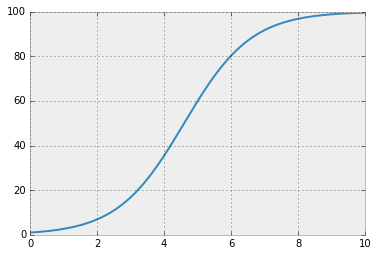

In [4]:
# Test problem
def f(t, x):
    # Logistic equation
    R = 1
    K = 100
    return R*x*(1 - x/K)

# Get the trajectory, using Runge-Kutta and a fairly short timestep
Ts, Xs = get_trajectory(f, rk4, t_max = 10, h0 = 1e-4, x0 = 1, t0 = 0)
plt.plot(Ts, Xs)

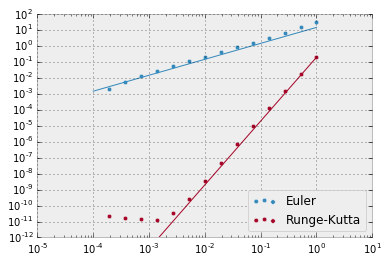

In [22]:
# To compare integrators, we wil run with the above test function,
# until t_max = 6

# First, we compare the performance of Euler and Runge-Kutta
# by plotting 'error' as a function of timestep.
# Here, we define 'error' as the difference between the endpoint
# for a given timestep and the shortest timestep tested

timesteps = np.logspace(-4, 0, 15)

X_E  = []
X_RK = []
for h in timesteps:
    t, x = get_endpoint(f, euler, t_max = 6, h0 = h, x0 = 1, t0 = 0)
    X_E.append(x)
    t, x = get_endpoint(f, rk4, t_max = 6, h0 = h, x0 = 1, t0 = 0)
    X_RK.append(x)
    
X_E  = np.array(X_E)
X_RK = np.array(X_RK)
l, = plt.plot(timesteps, 15.0*timesteps**1, lw = 1)
plt.scatter(timesteps[1:], abs(X_E[1:] - X_E[0]), label = 'Euler', c = l.get_color())
l, = plt.plot(timesteps, 0.20*timesteps**4, lw = 1)
plt.scatter(timesteps[1:], abs(X_RK[1:] - X_RK[0]), label = 'Runge-Kutta', c = l.get_color())
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-5, 10)
plt.ylim(1e-12, 100)
plt.legend(loc = 'lower right')

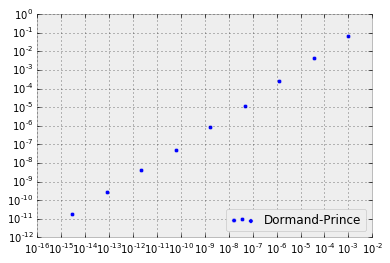

In [27]:
# Then, we run Dormand-Prince with different tolerances,
# and again calculate the 'error' relative to the most accurate result

tolerances = np.logspace(-16, -3, 10)

X_DP = np.zeros(len(tolerances))
for i, tol in enumerate(tolerances):
    t, x = get_endpoint(f, dopri5, t_max = 6, h0 = 1e-3, x0 = 1, t0 = 0, atol = tol, rtol = tol)
    X_DP[i] = x

plt.scatter(tolerances[1:], abs(X_DP[1:] - X_DP[0]), label = 'Dormand-Prince')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-16, 1e-2)
plt.ylim(1e-12, 1e0)
plt.legend(loc = 'lower right')

## Comparison of time

Based on the above, we can conclude that in order to get an error of about $10^{-2}$ in the final position, we need a steplength of about $h=5\cdot10^{-4}$ for the Euler integrator, about $h = 4\cdot 10^{-1}$ for Runge-Kutta, and we need to set a tolerance of about $10^{-4}$ for the Dormand-Prince integrator.

For a smaller error, for example $10^{-9}$, the Euler integrator probably won't be able to deliver no matter how short the timestep, due to accumulation of numerical error. To get this precision with the Runge-Kutta integrator, we need a step length of about $h= 6\cdot10^{-3}$, and for Dormand-Prince we need a tolerance of about $5 \cdot 10^{-13}$.

In [32]:
# Comparison of all three integrators
tic = time()
Ts, Xs = get_trajectory(f, euler, t_max = 6, h0 = 5e-4, x0 = 1, t0 = 0)
toc = time()
print('Euler, %s steps, %s seconds' % (len(Ts), toc - tic))

tic = time()
Ts, Xs = get_trajectory(f, rk4, t_max = 6, h0 = 4e-1, x0 = 1, t0 = 0)
toc = time()
print('Runge-Kutta, %s steps, %s seconds' % (len(Ts), toc - tic))

tic = time()
Ts, Xs = get_trajectory(f, dopri5, t_max = 6, h0 = 1e-3, x0 = 1, t0 = 0, atol = 1e-4, rtol = 1e-4)
toc = time()
print('Dormand-prince, %s steps, %s seconds' % (len(Ts), toc - tic))

Euler, 12002 steps, 0.02181410789489746 seconds
Runge-Kutta, 16 steps, 0.0007688999176025391 seconds
Dormand-prince, 9 steps, 0.0005540847778320312 seconds


In [49]:
# Comparison of Runge-Kutta and Dormand-Prince
tic = time()
Ts, Xs = get_trajectory(f, rk4, t_max = 6, h0 = 4e-2, x0 = 1, t0 = 0)
toc = time()
print('Runge-Kutta, %s steps, %s seconds' % (len(Ts), toc - tic))

tic = time()
Ts, Xs = get_trajectory(f, dopri5, t_max = 6, h0 = 1e-2, x0 = 1, t0 = 0, atol = 2e-9, rtol = 2e-9)
toc = time()
print('Dormand-prince, %s steps, %s seconds' % (len(Ts), toc - tic))

Runge-Kutta, 151 steps, 0.0007231235504150391 seconds
Dormand-prince, 65 steps, 0.0030951499938964844 seconds


## Restricted thee-body problem

See Hairer, Wanner & Nørsett, *Solving Ordinary Differential Equations I: Nonstiff problems*.

In [21]:
def f(t, x):
    mu  = 0.012277471
    mu_ = 1 - mu
    D1  = ((x[1] + mu )**2 + x[3]**2)**(3/2)
    D2  = ((x[1] - mu_)**2 + x[3]**2)**(3/2)
    dx  = np.zeros(4)
    dx[0] = x[1] + 2*x[2] - mu_*(x[1] + mu)/D1 - mu*(x[1] - mu_)/D2
    dx[1] = x[0]
    dx[2] = x[3] - 2*x[0] - mu_*x[3]/D1        - mu*x[3]/D2
    dx[3] = x[2]
    return dx

(-1.2, 1.2)

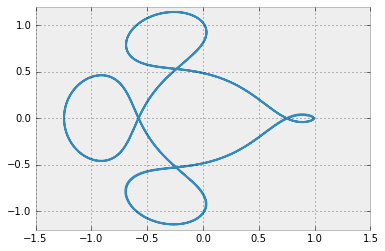

In [61]:
# Initial values
x0 = np.array([
        0.0,
        0.994,
        -2.00158510637908252240537862224,
        0.0
    ])
Tmax = 2*17.06521656
dt   = 3e-4
Nt   = int(Tmax / dt)

X = np.zeros((4, Nt + 2))
X[:,0] = x0
t = 0
i = 0
while t <= Tmax:
    t_, x_, h_ = rk4(t, X[:,i], dt, f)
    X[:,i+1] = x_
    t = t_
    i += 1
    
plt.plot(X[1,:], X[3,:])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.2, 1.2)

(-1.2, 1.2)

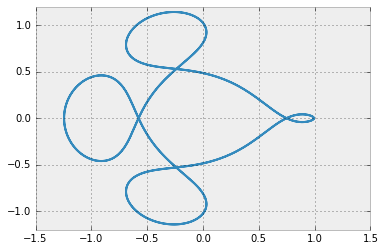

In [62]:
# Initial values
x0 = np.array([
        0.0,
        0.994,
        -2.00158510637908252240537862224,
        0.0
    ])
Tmax = 2*17.06521656
dt   = 1e-3
Nt   = int(Tmax / dt)

X = np.zeros((4, Nt + 2))
X[:,0] = x0
t = 0
i = 0
while t <= Tmax:
    t_, x_, dt = dopri5(t, X[:,i], dt, f, atol = 1e-9, rtol = 1e-9)
    if t_ > t:
        X[:,i+1] = x_
        t = t_
        i += 1
plt.plot(X[1,:i], X[3,:i])
plt.xlim(-1.5, 1.5)
plt.ylim(-1.2, 1.2)